# RA Diagnosis Example - Machine Learning
https://blog.socialcops.com/technology/data-science/machine-learning-python/

In [1]:
import buildingAClassifier as bc
import sys
sys.path.append('../')
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
from sklearn import __version__ as sk_vers
import re
import random
SEED = 26062019

test_size = 0.5 

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('pattern version:\t' + pat_vers)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.14.3
sklearn version:	0.21.2
pattern version:	3.6


In [3]:
def binarize(value):
    if value == 'j':
        return 'y'
    elif value == 'n':
        return 'n'
    elif value == 'p':
        return 'n'

radiag_df = pd.read_csv(r'annotation_v2_20190125.csv', index_col=0, sep="|", na_values=['NA'])
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x : binarize(x)) 
lemma_radiag_df = radiag_df.copy()
print('Nr of entries:', len(radiag_df))
#radiag_df.head()

Nr of entries: 1361


## Step 1: Cleaning Data

### Preprocessing - Word segmentation and lemmatizing 

In [4]:
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x))
lemma_radiag_df['XANTWOORD'] = lemma_radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=True))
#lemma_radiag_df.head(5)

### Balancing classes in data (50% RA cases and 50% non cases)
number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes.

In [5]:
df_no_outcome = lemma_radiag_df[lemma_radiag_df['Outcome']=='n'].sample(len(lemma_radiag_df[lemma_radiag_df['Outcome']=='y']), random_state=SEED)
equal_radiag_df = pd.concat([df_no_outcome, lemma_radiag_df[lemma_radiag_df['Outcome']=='y']])
equal_radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

#### Positive control -> classes should be in balance

(439, 439)


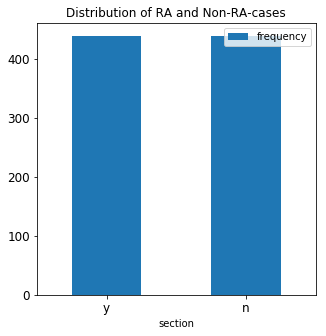

In [6]:
from collections import Counter

labels, values = zip(*Counter(equal_radiag_df['Outcome']).items())
print(values)

df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

In [12]:
X = equal_radiag_df['XANTWOORD'].values
y = equal_radiag_df[['ID', 'Outcome']].values
y_tot = equal_radiag_df['Outcome'].values

#X_train, X_test, y_full_train, y_full_test = model_selection.train_test_split(X,y,test_size=test_size, random_state=SEED)
#y_train = y_full_train[range(0,len(y_full_train)),1]
#y_test = y_full_test[range(0,len(y_full_test)),1]

## Step 2: Building the Pipeline & Fitting the Models

First: Import important modules

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier


In [7]:
import scipy.stats as ss
import collections
from pyConTextNLP import itemData
import pyConTextNLP
from textblob import TextBlob
import re

def simple_rulebased(report):
    regexp = re.compile(r'\b((rheumatoid|reumatoide)\s(arthritis|artritis)|ra)\b')
    if regexp.search(report):
        return 'y'
    else :
        return 'n'


### Different options:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [9]:
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 4 - NuSVC probability
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', NuSVC(probability=True,random_state=SEED)),
            ]),
    # Random Forest 5 
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 6
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DummyClassifier(random_state=SEED)),
            ])
    ]


### Load function required for ROC-plot visualisation 

In [14]:
import buildingAClassifier as bC
import importlib
importlib.reload(bC)
l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']
WordMatching = bC.CustomBinaryModel(l_targets)

## Step 3: Evaluate
Visualize performance of the models in ROC curve

Word Matching 0.7539219616229005 (std : +/-0.01958155283532 )
Decision Tree 0.8344517497403452 (std : +/-0.02073529809788606 )
Naive Bayes 0.863115949992258 (std : +/-0.013514723158018032 )
Gradient Boosting 0.935374449128089 (std : +/-0.0077444283810952 )
Neural Networks 0.8945720040038725 (std : +/-0.02359934590673768 )


E:\modules\Anaconda\Program\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM 0.900156190077304 (std : +/-0.010696673999879218 )
Random Forest 0.8860982709754429 (std : +/-0.010801975365410986 )
Dummy 0.49177325611087247 (std : +/-0.012880743028026694 )


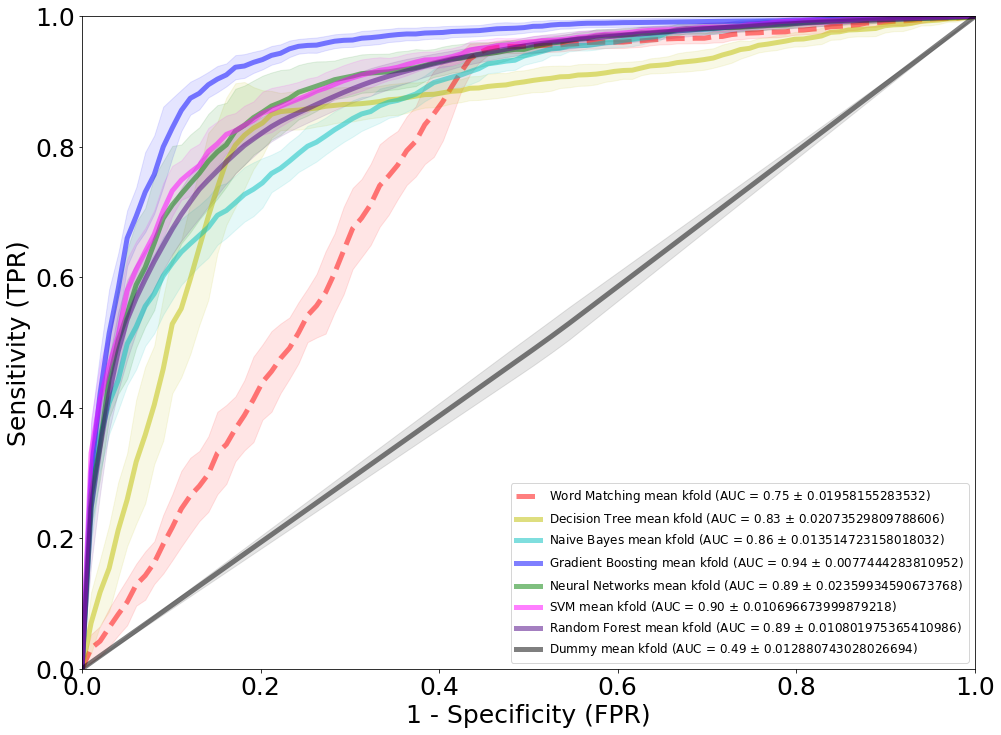

In [15]:
import matplotlib.pyplot as plt

lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM', 'Random Forest', 'Dummy']

l_folds = bC.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:7] # exclude decision -> because it cant assess the probabilities!
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(16,12))

plt, ref_auc, auc_ref, fitted_wm = bC.plotCustomModelROC(WordMatching, X, y_tot, l_folds, 'Word Matching', 'r', '--') # custom made roc
plt, dt_auc, auc_dt, fitted_dt = bC.plotBinaryROC(pipe_list[3], 'Decision Tree', X, y_tot, l_folds, 'y')
plt, d_aucs, fitted_models = bC.plotCrossValidationROC(filtered_pipe,'ROC curve for different classification methods', lbls, X, y_tot, l_folds, ref_auc)


### Test performance relative to Naive Word Matching

In [16]:
import scipy

for key in d_aucs.keys(): # classifiers with probas
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

print('Decision Tree\t(p =', scipy.stats.ttest_ind(auc_dt, auc_ref)[1], ')')

Naive Bayes 	(p = 4.952012056716044e-11 )
Gradient Boosting 	(p = 1.0871919276893494e-15 )
Neural Networks 	(p = 5.107334874965387e-11 )
SVM 	(p = 1.1497830096476107e-13 )
Random Forest 	(p = 7.137698159469687e-13 )
Dummy 	(p = 1.1143560900157703e-17 )
Decision Tree	(p = 1.0537843963980759e-07 )


### Evaluate Performance on lower prevalence of RA-cases

GBM 50/50 0.9351564355415914 (std : +/-0.007242970133448076 )
GBM .20 0.926842063241751 (std : +/-0.021942570804383988 )
GBM .05 0.9253536606540328 (std : +/-0.04203690493202103 )
0.04203690493202103


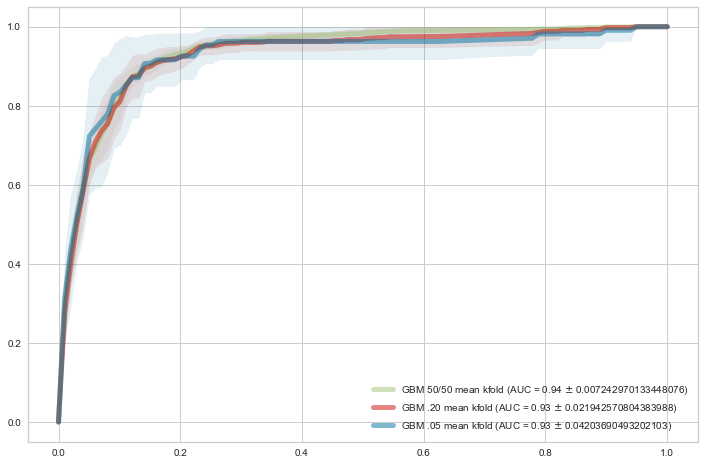

In [53]:
from scipy import interp


plt.figure(figsize=(12,8))
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([binarize(val) for val in y_tot]), 1, 'GBM 50/50', 'g')
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([binarize(val) for val in y_tot]), .2, 'GBM .20', 'r')
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([binarize(val) for val in y_tot]), .05, 'GBM .05', 'b')
print(mean_auc)

### Measure time performance
tp_list = time point list (necessary for calculating the standard deviation)

In [204]:
import time
import statistics

print('Training Time (Mean of 100 iterations):\n')
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'Decision Tree', 'SVM', 'Rule based']
tot_it = 3

for x in range(len(lbls)-1): # all methods except for rule based are fitted
    tp_list = []
    t0 = time.time()
    for y in range(tot_it):
        t2 = time.time()
        pipe_list[x].fit(X_train, y_train)
        tp_list.append(time.time() - t2) 
    t1 = time.time()
    total = t1-t0
    print(lbls[x], ' : %0.2f seconds' % (total/tot_it), '\tSTD: %0.2f' % statistics.stdev(tp_list))
    
print('\nTesting Time (Mean of 100 iterations):\n')
for x in range(len(lbls)):
    tp_list = []
    t0 = time.time()
    for y in range(tot_it):
        t2 = time.time()
        pipe_list[x].predict_proba(X_test)[:,1]
        tp_list.append(time.time() - t2) 
    t1 = time.time()
    total = t1-t0
    print(lbls[x], ' : %0.2f seconds' % (total/tot_it), '\tSTD: %0.2f' % statistics.stdev(tp_list))


Training Time (Mean of 100 iterations):

Naive Bayes  : 0.02 seconds 	STD: 0.00
Gradient Boosting  : 0.27 seconds 	STD: 0.02
Neural Networks  : 0.20 seconds 	STD: 0.00
Decision Tree  : 0.02 seconds 	STD: 0.01


E:\modules\Anaconda\Program\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM  : 0.12 seconds 	STD: 0.01

Testing Time (Mean of 100 iterations):

Naive Bayes  : 0.01 seconds 	STD: 0.01
Gradient Boosting  : 0.01 seconds 	STD: 0.01
Neural Networks  : 0.01 seconds 	STD: 0.01
Decision Tree  : 0.01 seconds 	STD: 0.01
SVM  : 0.03 seconds 	STD: 0.01
Rule based  : 0.01 seconds 	STD: 0.00


## Incorrect predictions

In [17]:
predictions = estimator.predict(X_test_fold)
for inp, prediction, label in zip(X_test_fold, predictions, y_test_fold):
    #print(inp, prediction, label)
    if prediction != label:
        print('"', inp, '"\n\n', 'has been classified as ', prediction, 'and should be ', label, '\n') 
print('Cannot print example of output')

Cannot print example of output


## Step 4: Insight into the black box 
Optional Visualizations -> of best model & median Fold

In [18]:
gbm_model = fitted_models['Gradient Boosting']
print(len(gbm_model))
estimator = gbm_model[2]
test_index = gbm_model[3]
train_index = gbm_model[4]
X_test_fold = X[test_index]
X_train_fold = X[train_index]
y_test_fold = np.array([binarize(val) for val in y_tot])[test_index]
b_y_train_fold = np.array([binarize(val) for val in y_tot])[train_index]
y_train_fold = y_tot[train_index]

5


### Visualize Decision Tree - graphviz 
Outputs a file that can be visualized in http://viz-js.com/ 

In [21]:
import graphviz
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_fold) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = tree.DecisionTreeClassifier(criterion='entropy')

test_clf = clf.fit(X_train_tfidf, y_train_fold)

dot_data = tree.export_graphviz(test_clf, out_file=None, feature_names=count_vect.get_feature_names(), class_names=['POSITIVE', 'NEGATIVE'],  
        filled=True, rounded=True, special_characters=False, proportion=True)  
        
graph = graphviz.Source(dot_data) 
graph.save("GraphViz/DecisionTree_structure")

'GraphViz/DecisionTree_structure'

### GraphViz Random Forest

In [22]:
from sklearn.tree import export_graphviz
import os 

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_fold) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = RandomForestClassifier(n_estimators=100, 
                max_depth=2, random_state=0)

test_clf = clf.fit(X_train_tfidf, y_train_fold)


dot_data = export_graphviz(test_clf.estimators_[0], feature_names=count_vect.get_feature_names(), class_names=['POSITIVE', 'NEGATIVE'],  
        filled=True, rounded=True, special_characters=True, proportion=True) 
graph = graphviz.Source(dot_data) 
graph.save("GraphViz/RandomForest_structure")

'GraphViz/RandomForest_structure'

### Pearson correlation per feature

Bbox(x0=-0.26730049562526126, y0=0.09999999999999998, x1=0.4459589635003584, y1=19.900000000000002)


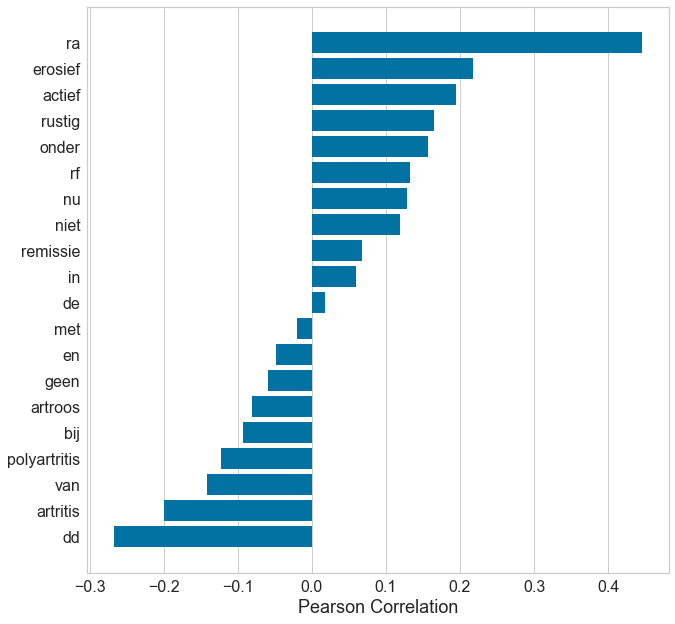

In [38]:


from sklearn import datasets
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import StandardScaler
import seaborn as sns

plt.figure(figsize=(8,6))
# Load the regression data set
Xs, ys = X_train_tfidf, y_train_fold
feature_names = np.array(count_vect.get_feature_names())
X_pd = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

# Transform
trans = StandardScaler()
trans.fit(X_pd)
def binarize(value):
    return int(value == 'y')
Y_pd = pd.DataFrame(y_tot[train_index])[0].apply(lambda x : binarize(x))
X_pd2 = pd.DataFrame(trans.transform(X_pd), columns=count_vect.get_feature_names())

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) #['ra', 'dd', 'reumatoide', 'artritis', 'patient', 'de', 'het', 'spa', 'methotrexaat', 'prednison']
#feature_to_plot.append('psoriatica')

visualizer = FeatureCorrelation(labels=feature_to_plot, size=(750, 750), sort=True)

visualizer.fit(X_pd2[feature_to_plot], Y_pd)
ax = visualizer.ax
ax.set_xlabel('Pearson Correlation', fontsize=18)
ax.tick_params(labelsize=16)

visualizer.finalize()
plt.rcParams.update({'font.size': 55})
plt.title('', fontsize=20, fontweight='bold')
#ax.set_yticklabels(labels=['ra', 'active', 'erosive', 'on', 'not-active', 'mtx', 'rf', 'remission', 'not', 'currently', 'the', 'and', 'with', 'mg', 'in', 'no', 'of/from', 'in case of/by', 'arthritis', 'dd'][::-1])

print(ax.dataLim)

plt.show()


# of the top 20 features with the highest corrected term frequency

### Explained variance per feature
The importance of each feature reflects the model error caused by exclusion of said feature

[0.00257405 0.00328387 0.00504167 0.00780466 0.01051548 0.01126287
 0.01256318 0.01475805 0.01794646 0.01995795 0.02028889 0.02515803
 0.0252017  0.03371764 0.03838996 0.04546714 0.05802531 0.06397926
 0.21416141 0.36990242]


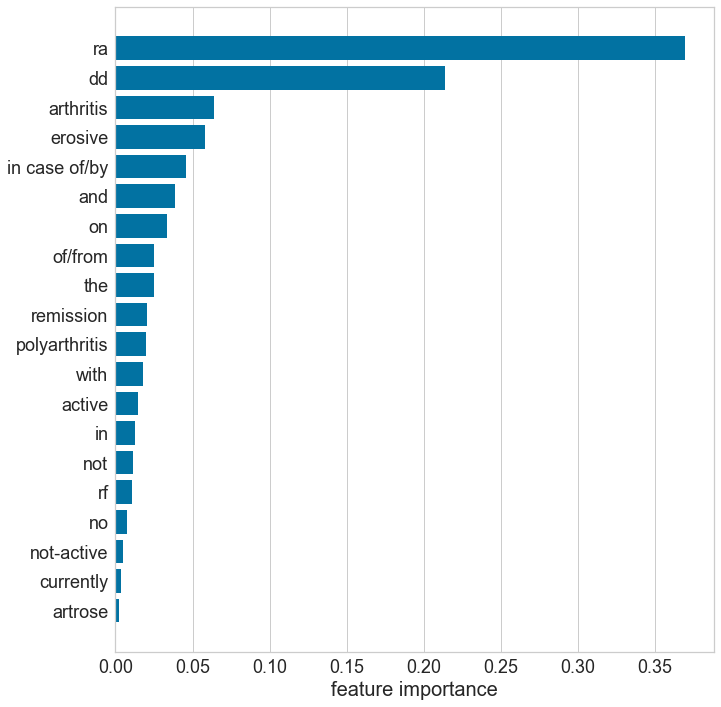

In [55]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) 
viz = FeatureImportances(GradientBoostingClassifier(), size=(750, 750), relative=False)

#feature_to_plot.append('reumatoide')

viz.fit(X_pd[feature_to_plot], y_tot[train_index])
print(viz.feature_importances_) # Print values 
ax = viz.ax
ax.tick_params(labelsize=18)
ax.set_yticklabels(labels=['ra', 'dd', 'arthritis', 'erosive', 'in case of/by', 'and', 'on', 'of/from', 'the', 'remission', 'polyarthritis', 'with', 'active', 'in', 'not', 'rf', 'no', 'not-active', 'currently', 'artrose'][::-1])
ax.set_xlabel('Feature Importance', fontsize=20)

viz.finalize()

plt.title('', fontsize=28, fontweight='bold')
# Feature Importances of top 20 features using Gradient Boosting

plt.show()


## Step 5: Extra

### T-sne on top 10 most occuring features

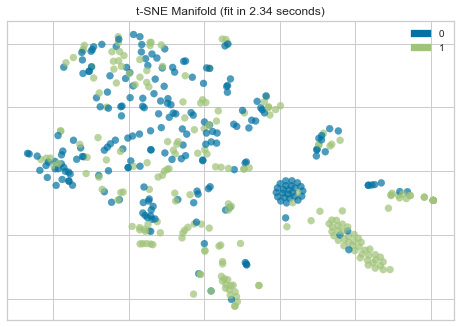

In [251]:
from yellowbrick.features.manifold import Manifold
feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:10]) 
visualizer = Manifold(manifold='tsne', target='discrete')
#arbit_list = ['en', 'rustig']
visualizer.fit_transform(X_pd2[feature_to_plot],Y_pd)
visualizer.poof()

E:\modules\Anaconda\Program\lib\site-packages\yellowbrick\features\radviz.py:213: RuntimeWarning: invalid value encountered in true_divide
  xy   = (s * row_).sum(axis=0) / row.sum()


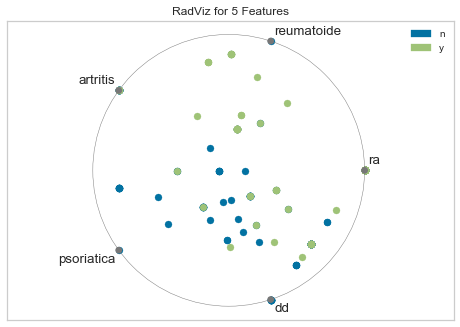

In [265]:
from yellowbrick.features import RadViz
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 16})
vzr = RadViz(classes=['n', 'y'])
trans = StandardScaler()
trans.fit(X_pd)
def binarize(value):
    return int(value == 'y')

Y_pd = pd.DataFrame(y_train)[0].apply(lambda x : binarize(x))
X_pd2 = pd.DataFrame(trans.transform(X_pd), columns=count_vect.get_feature_names())
#print(X_pd2)
feature_to_plot = ['ra', 'reumatoide', 'artritis',  'psoriatica', 'dd']# list(X_pd2.sum().sort_values(ascending=False).keys()[:100]) 
vzr.fit_transform(X_pd2[feature_to_plot], np.array(Y_pd))
vzr.poof()


### Visualize Gradient Boosting - graphviz
Outputs a file that can be visualized in http://viz-js.com/ 

In [266]:

import graphviz 

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = ske.GradientBoostingClassifier(n_estimators=50)
test_clf = clf.fit(X_train_tfidf, y_train)
sub_tree_49 = clf.estimators_[1, 0]

dot_data = tree.export_graphviz(
    sub_tree_49, 
    out_file=None, feature_names=count_vect.get_feature_names(), class_names=['POSITIVE', 'NEGATIVE'],  
        filled=True, rounded=True, special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data) 
graph.save("Predicting RA diagnosis GBM")
#graph.render("Predicting RA diagnosis") 


'Predicting RA diagnosis GBM'

### Visualize Learning Curve
To determine the optimal sample size for the trainingsset

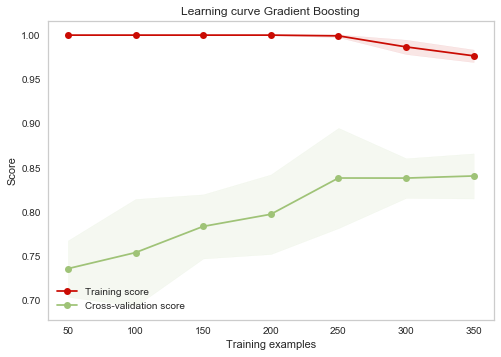

In [267]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

clf = ske.GradientBoostingClassifier(n_estimators=50) # tree.DecisionTreeClassifier(random_state=777)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

plot = bc.plot_learning_curve(clf, 'Learning curve Gradient Boosting', X_train_tfidf, y_train, train_sizes=[50, 100, 150, 200, 250, 300, 350], cv=5)

plot.show()

## Extra fitting steps: GridSearchCV - optimizing Parameters
Useful if models show a consistently bad performance in the trainingsset!

In [229]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3),}
#gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1) # n_jobs -> multiple cores
#gs_clf = gs_clf.fit(X_train, y_train)

In [268]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X2 = digits.images.reshape((n_samples, -1))
y2 = digits.target

# Split the dataset in two equal parts
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.5, random_state=0)

# Set the parameters by cross-validation

epochs = [5, 10]
batches = [5, 10, 100]
optimizers = ['rmsprop', 'adam']

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 20, 30]},
                    {'kernel': ['linear'], 'C': [1, 10, 20, 30]}]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 20, 30]},
                    {'kernel': ['linear'], 'C': [1, 10, 20, 30]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train2, y_train2)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true2, y_pred2 = y_test2, clf.predict(X_test2)
    print(classification_report(y_true2, y_pred2))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
0.985 (+/-0.019) for {'C': 20, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 30, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.022) for {'C': 30, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 20, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 30, 'kernel': 'linear'}

Detailed classification report:

The model is traine